# Brain MRI classification using Deep Learning

Nesta atividade, o objetivo, mais uma vez, é classificar imagens de ressonância magnética do cérebro em imagens com tumor (*tumor*) e imagens sem tumor (*health*). Para simplificar a tarefa, as imagens já foram processadas e, ao invés de serem fornecidas como imagens volumétricas (3D) em formato DICOM, elas estão sendo fornecidas como fatias (imagens 2D) e no formato jpg.

Em contraste com a atividade da semana passada, usaremos uma rede neural convolucional (CNN) para a classificação. Ou seja, diferentemente do *pipeline* de classificação tradicional, os atributos serão extraídos pela própria CNN e não teremos que nos preocupar com isso.

Este notebook mostra como se faz para carregar as imagens, descrever a CNN a ser usada, treinar e predizer. O treinamento mostrado não trata os dados antes de inseri-los na rede nem utiliza as técnicas mais avançadas de Deep Learning, como *data augmentation* e *transfer learning*. A ideia é que você explore estes passos adicionais, tentando melhorar a acurácia de classificação.


In [60]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import time
import os
import copy
from sklearn.metrics import confusion_matrix

plt.ion()   # interactive mode

# connect drive
#from google.colab import drive
#drive.mount('/content/gdrive')

#!ls 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'

In [61]:
DATA_DIR = './DataSets/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/JeanKusanagi/DataSets ./DataSets')
    print('Done!')

import pathlib
PATH = "/content/DataSets/Brain_Tumor/"
PATH = pathlib.Path(PATH)

In [62]:
# Number of epochs to train for
EPOCHS = 10

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
EPOCHS = 10

input_size = 224

string_all = []
sensibilidade_all = []
especificidade_all = []
acc_all = []

##**Funções**

In [63]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc)
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc)
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def predic_model(model, plot_img = False, num_images=24):
    was_training = model.training
    model.eval()
    images_so_far = 0
    PREDICTED = []
    LABEL = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(len(labels))

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
              images_so_far += 1
              PREDICTED.append(class_names[preds[j]])
              LABEL.append(class_names[labels[j]])
              if plot_img:
                plt.figure()
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                plt.axis('off')
                plt.title('predicted: {} - label: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                plt.plot()

              if images_so_far == num_images:
                model.train(mode=was_training)
                # break
                return PREDICTED, LABEL

        model.train(mode=was_training)

    return PREDICTED, LABEL

#**Parte 1 - Carregando os dados (imagens e rótulos) usando o DataLoader**

Normalmente treinamento de CNNs pressupõe o uso de conjuntos de dados muito grandes. O carregamento destes conjuntos de dados em um NB pode dar bastante trabalho e causar problemas, como falta de memória, dentre outros. Para isso, costumamos usar um *dataloader*, especificamente desenvolvido para isso. Para mais informações sobre *dataloader* consulte o [link](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

**Pre-processamento dos dados e Data Augmentation**

As tranformações que queremos fazer nos dados precisam ser definidas antes de chamar o DataLoader. Assim, quando ele carrega os dados, já aplica as transformações desejadas. Você verá que a única transformação que está sendo feita é um redimensionamento das imagens (transform.Resize). Isso é feito pois a CNN só consegue lidar com imagens de treinamento do mesmo tamanho. As outras linhas comentadas da parte do código que faz as transformações dos dados podem ser usadas e modificadas, como forma de fazer um aumento de dados e assim, ajudar no treino. Consulte a documentação sobre *transforms* do Pytorch: https://pytorch.org/vision/stable/transforms.html.

**ATENÇÃO**
Se você escolheu aplicar alguma transformação (por ex: *resize*, *normalize*) com o intuito de pre-processamento, você deve aplicá-la a todos os conjuntos (**train, val, test**). Porém, se você escolheu uma transformação (por ex: *RandomHorizontalFlip*) como forma de aumento de dados, ela deve ser aplicada somente ao conjunto de treinamento (**train**) e, de preferência, de forma aleatória.

In [64]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(5),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(5),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((170,170)),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1),
        transforms.ToTensor(),
    ]),
}

##data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'
data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## **Visualizando algumas imagens (one batch)**

Muitas vezes treinamos uma rede neural em *batches*, quer dizer, separamos o conjunto de treino em sub-conjuntos menores. Se temos um conjunto de treino de M amostras, podemos ter M *batches* de tamanho 1 até 1 *batch* de tamanho M. Nesse nosso exemplo, escolhemos um tamanho de batch = 24. Para mais detalhes sobre como escolher o tamanho de um *batch*, veja este [link](https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e) . 

Batch of training data


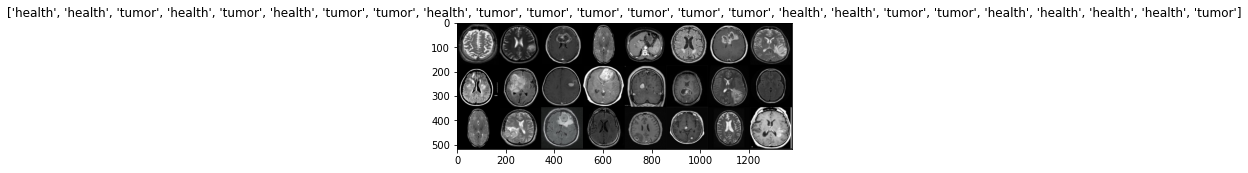

min =  0.0
median =  0.21176471
mean =  0.24004653
max =  1.0
Batch of validation data


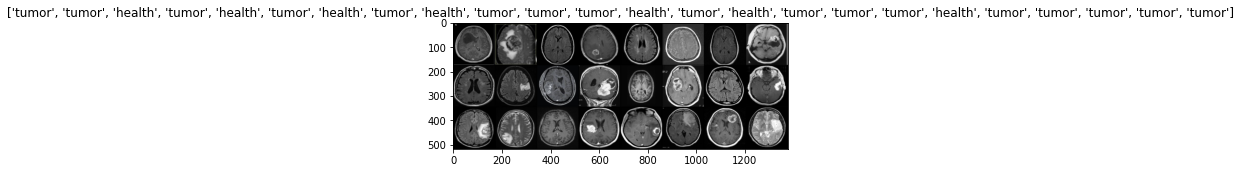

min =  0.0
median =  0.2627451
mean =  0.26848122
max =  1.0
Batch of test data


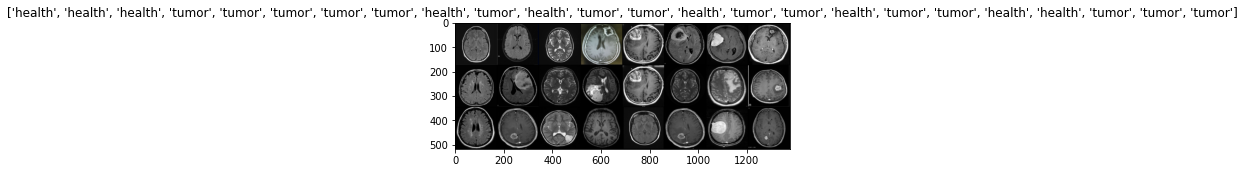

min =  0.0
median =  0.23137255
mean =  0.24494132
max =  1.0


In [65]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))


print('Batch of validation data')
inputs, classes = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

print('Batch of test data')
inputs, classes = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

#**Parte 2 - Definindo o modelo a ser treinado e os parâmetros de treinamento**

Antes de começar a treinar uma CNN, é preciso definir o processo de treinamento e os parâmetros iniciais do modelo a ser treinado (arquitetura, learning rate, critério de otimização, etc). Não se preocupe com a primeira parte do código (2.1), de definição do processo de treinamento. Se quiser tentar melhorar a acurácia mexendo no modelo, altere os parâmetros do modelo (2.2). Você verá que neste trecho há várias linhas comentadas, dando ideias de possíveis alterações. Para a documentação sobre parâmetros de treinamento: [link](https://pytorch.org/docs/stable/optim.html)

###**2.1 - Definindo o processo de treinamento**

###**2.2 - Definindo os parâmetros do modelo e do treinamento**

In [66]:
# Carrega uma arquitetura já conhecida: ResNet18. O parâmetro "pretrained" define o uso ou não de "Transfer Learning"
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features

# Define a sáida de tamanho 2 (Duas classes).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device) #usa a GPU, se disponível e a CPU caso contrário

# Escolha da Loss Function (critério de otimização da classificação)
criterion = nn.CrossEntropyLoss()

# Parâmetros de treinamento que podem ser alterados

# optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.0008, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.000005, momentum=0.9)

# Decay LR by a factor of "gamma" every "step_size" epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)

In [67]:
# print(model) # mostrando a arquitetura da CNN escolhida

summary(model, (3, 170, 170)) # summarize the model 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 85, 85]           9,408
       BatchNorm2d-2           [-1, 64, 85, 85]             128
              ReLU-3           [-1, 64, 85, 85]               0
         MaxPool2d-4           [-1, 64, 43, 43]               0
            Conv2d-5           [-1, 64, 43, 43]          36,864
       BatchNorm2d-6           [-1, 64, 43, 43]             128
              ReLU-7           [-1, 64, 43, 43]               0
            Conv2d-8           [-1, 64, 43, 43]          36,864
       BatchNorm2d-9           [-1, 64, 43, 43]             128
             ReLU-10           [-1, 64, 43, 43]               0
       BasicBlock-11           [-1, 64, 43, 43]               0
           Conv2d-12           [-1, 64, 43, 43]          36,864
      BatchNorm2d-13           [-1, 64, 43, 43]             128
             ReLU-14           [-1, 64,

#**Parte 3 - Treinando a CNN**

In [68]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

# model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler, num_epochs=200)
r_model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 0.7554 Acc: 0.3920
val Loss: 0.7161 Acc: 0.3725

Epoch 1/9
----------
train Loss: 0.7027 Acc: 0.4886
val Loss: 0.7055 Acc: 0.3529

Epoch 2/9
----------
train Loss: 0.6602 Acc: 0.6193
val Loss: 0.6835 Acc: 0.5882

Epoch 3/9
----------
train Loss: 0.6498 Acc: 0.6136
val Loss: 0.6681 Acc: 0.6275

Epoch 4/9
----------
train Loss: 0.6430 Acc: 0.6080
val Loss: 0.6647 Acc: 0.6471

Epoch 5/9
----------
train Loss: 0.6306 Acc: 0.6080
val Loss: 0.6627 Acc: 0.6471

Epoch 6/9
----------
train Loss: 0.6223 Acc: 0.6193
val Loss: 0.6579 Acc: 0.6078

Epoch 7/9
----------
train Loss: 0.6191 Acc: 0.6307
val Loss: 0.6472 Acc: 0.5882

Epoch 8/9
----------
train Loss: 0.6120 Acc: 0.6307
val Loss: 0.6361 Acc: 0.6275

Epoch 9/9
----------
train Loss: 0.6064 Acc: 0.6705
val Loss: 0.6262 Acc: 0.6275

Training complete in 0m 12s
Best val Acc: 0.647059


###**Mostrando as curvas de treinamento**

Através das curvas de acurácia e de erro nos conjuntos de treinamento e validação, é possível responder algumas perguntas com relação ao treinamento: houve *overfitting*? o número de épocas não foi suficiente? Quando treinamos uma CNN, é importante observarmos essas curvas e não somente a acurácia final. Há vários textos sobre como avaliar o treinamento de um modelo a partir das curvas, veja um exemplo [aqui](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

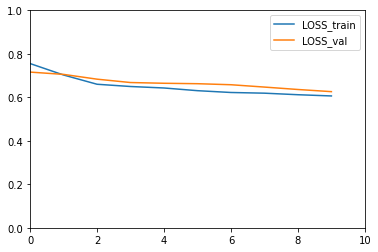

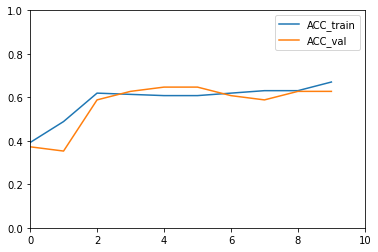

max ACC =  tensor(0.6471, device='cuda:0', dtype=torch.float64)


In [69]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

###**Visualizando as predições no grupo de teste**

In [70]:
test_group_len = 26
PREDICTED, LABEL = predic_model(r_model, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Original')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'health', 'tumor']
predições =  ['tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor']
matriz de confusão = 
 [[ 0 10]
 [ 0 16]]
Sensibilidade =  1.0
Especificidade =  0.0
acc =  0.6153846153846154


# Modificações

## Versão 1

* RandomResizedCrop(input_size)
* RandomHorizontalFlip()
* ToTensor()
* Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [71]:
# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

##data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'
data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [72]:
# Carrega uma arquitetura já conhecida: ResNet18. O parâmetro "pretrained" define o uso ou não de "Transfer Learning"
model_v1 = models.resnet18(pretrained=False)
num_ftrs = model_v1.fc.in_features

# Define a sáida de tamanho 2 (Duas classes).
model_v1.fc = nn.Linear(num_ftrs, 2)

model_v1 = model_v1.to(device) #usa a GPU, se disponível e a CPU caso contrário

# Escolha da Loss Function (critério de otimização da classificação)
criterion = nn.CrossEntropyLoss()

# Parâmetros de treinamento que podem ser alterados

# optimizer_ft = optim.SGD(model_v1.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v1.parameters(), lr=0.0008, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v1.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft_randstart = optim.SGD(model_v1.parameters(), lr=0.00005, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v1.parameters(), lr=0.000005, momentum=0.9)

# Decay LR by a factor of "gamma" every "step_size" epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)

In [73]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

r_model_v1 = train_model(model_v1, criterion, optimizer_ft_randstart, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 0.7390 Acc: 0.3864
val Loss: 0.6994 Acc: 0.4902

Epoch 1/9
----------
train Loss: 0.7097 Acc: 0.5000
val Loss: 0.6929 Acc: 0.5686

Epoch 2/9
----------
train Loss: 0.6839 Acc: 0.5966
val Loss: 0.6814 Acc: 0.6078

Epoch 3/9
----------
train Loss: 0.6595 Acc: 0.6080
val Loss: 0.6700 Acc: 0.6275

Epoch 4/9
----------
train Loss: 0.6648 Acc: 0.6080
val Loss: 0.6717 Acc: 0.6275

Epoch 5/9
----------
train Loss: 0.6544 Acc: 0.6080
val Loss: 0.6715 Acc: 0.6275

Epoch 6/9
----------
train Loss: 0.6589 Acc: 0.6080
val Loss: 0.6749 Acc: 0.6275

Epoch 7/9
----------
train Loss: 0.6469 Acc: 0.6080
val Loss: 0.6821 Acc: 0.6078

Epoch 8/9
----------
train Loss: 0.6538 Acc: 0.6193
val Loss: 0.6796 Acc: 0.6471

Epoch 9/9
----------
train Loss: 0.6380 Acc: 0.6250
val Loss: 0.6792 Acc: 0.6078

Training complete in 0m 15s
Best val Acc: 0.647059


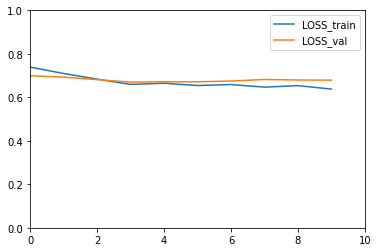

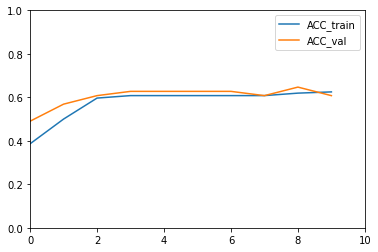

max ACC =  tensor(0.6471, device='cuda:0', dtype=torch.float64)


In [74]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [75]:
test_group_len = 26
PREDICTED, LABEL = predic_model(r_model_v1, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Versão 1')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health']
predições =  ['tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor']
matriz de confusão = 
 [[ 3  7]
 [ 0 16]]
Sensibilidade =  1.0
Especificidade =  0.3
acc =  0.7307692307692307


## Versão 2: norma de 0.5 até 0.5

In [76]:
# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]),
}

##data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'
data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [77]:
# Carrega uma arquitetura já conhecida: ResNet18. O parâmetro "pretrained" define o uso ou não de "Transfer Learning"
model_v2 = models.resnet18(pretrained=False)
num_ftrs = model_v2.fc.in_features

# Define a sáida de tamanho 2 (Duas classes).
model_v2.fc = nn.Linear(num_ftrs, 2)

model_v2 = model_v2.to(device) #usa a GPU, se disponível e a CPU caso contrário

# Escolha da Loss Function (critério de otimização da classificação)
criterion = nn.CrossEntropyLoss()

# Parâmetros de treinamento que podem ser alterados

# optimizer_ft = optim.SGD(model_v2.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v2.parameters(), lr=0.0008, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v2.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft_randstart = optim.SGD(model_v2.parameters(), lr=0.00005, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v2.parameters(), lr=0.000005, momentum=0.9)

# Decay LR by a factor of "gamma" every "step_size" epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)

In [78]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

# Train and evaluate
r_model_v2 = train_model(model_v2, criterion, optimizer_ft_randstart, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 0.7087 Acc: 0.6080
val Loss: 0.6668 Acc: 0.6275

Epoch 1/9
----------
train Loss: 0.6704 Acc: 0.6080
val Loss: 0.6837 Acc: 0.6275

Epoch 2/9
----------
train Loss: 0.6646 Acc: 0.6136
val Loss: 0.6768 Acc: 0.6275

Epoch 3/9
----------
train Loss: 0.6690 Acc: 0.5966
val Loss: 0.6637 Acc: 0.6275

Epoch 4/9
----------
train Loss: 0.6466 Acc: 0.5909
val Loss: 0.6586 Acc: 0.6275

Epoch 5/9
----------
train Loss: 0.6624 Acc: 0.5909
val Loss: 0.6614 Acc: 0.6275

Epoch 6/9
----------
train Loss: 0.6390 Acc: 0.6193
val Loss: 0.6599 Acc: 0.6863

Epoch 7/9
----------
train Loss: 0.6452 Acc: 0.6477
val Loss: 0.6586 Acc: 0.6863

Epoch 8/9
----------
train Loss: 0.6543 Acc: 0.6193
val Loss: 0.6610 Acc: 0.7059

Epoch 9/9
----------
train Loss: 0.6423 Acc: 0.6307
val Loss: 0.6628 Acc: 0.7059

Training complete in 0m 15s
Best val Acc: 0.705882


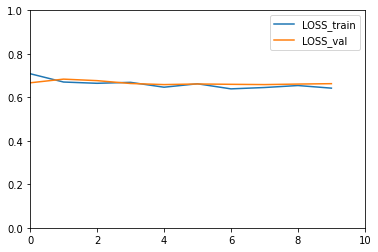

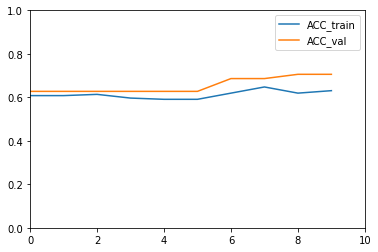

max ACC =  tensor(0.7059, device='cuda:0', dtype=torch.float64)


In [79]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [80]:
test_group_len = 26
PREDICTED, LABEL = predic_model(r_model_v2, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Versão 2')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor']
predições =  ['health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor']
matriz de confusão = 
 [[ 2  8]
 [ 0 16]]
Sensibilidade =  1.0
Especificidade =  0.2
acc =  0.6923076923076923


## Versão 3: norma de 0 até 1

In [81]:
# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(0, 1)
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(0, 1)
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(0, 1)
    ]),
}

##data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'
data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [82]:
# Carrega uma arquitetura já conhecida: ResNet18. O parâmetro "pretrained" define o uso ou não de "Transfer Learning"
model_v3 = models.resnet18(pretrained=False)
num_ftrs = model_v3.fc.in_features

# Define a sáida de tamanho 2 (Duas classes).
model.fc = nn.Linear(num_ftrs, 2)

model = model_v3.to(device) #usa a GPU, se disponível e a CPU caso contrário

# Escolha da Loss Function (critério de otimização da classificação)
criterion = nn.CrossEntropyLoss()

# Parâmetros de treinamento que podem ser alterados

# optimizer_ft = optim.SGD(model_v3.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v3.parameters(), lr=0.0008, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v3.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft_randstart = optim.SGD(model_v3.parameters(), lr=0.00005, momentum=0.9)
# optimizer_ft_randstart = optim.SGD(model_v3.parameters(), lr=0.000005, momentum=0.9)

# Decay LR by a factor of "gamma" every "step_size" epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)

In [83]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

r_model_v3 = train_model(model_v3, criterion, optimizer_ft_randstart, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 7.2150 Acc: 0.0000
val Loss: 6.9347 Acc: 0.0000

Epoch 1/9
----------
train Loss: 6.8634 Acc: 0.0000
val Loss: 6.7037 Acc: 0.0000

Epoch 2/9
----------
train Loss: 6.3420 Acc: 0.0000
val Loss: 6.3324 Acc: 0.0392

Epoch 3/9
----------
train Loss: 5.7449 Acc: 0.3636
val Loss: 5.8782 Acc: 0.6275

Epoch 4/9
----------
train Loss: 5.1175 Acc: 0.6023
val Loss: 5.3796 Acc: 0.6275

Epoch 5/9
----------
train Loss: 4.4671 Acc: 0.6080
val Loss: 4.8470 Acc: 0.6275

Epoch 6/9
----------
train Loss: 3.8632 Acc: 0.6080
val Loss: 4.2071 Acc: 0.6275

Epoch 7/9
----------
train Loss: 3.3307 Acc: 0.6080
val Loss: 3.4524 Acc: 0.6275

Epoch 8/9
----------
train Loss: 2.7977 Acc: 0.6080
val Loss: 2.6737 Acc: 0.6275

Epoch 9/9
----------
train Loss: 2.3843 Acc: 0.6080
val Loss: 2.0635 Acc: 0.6275

Training complete in 0m 15s
Best val Acc: 0.627451


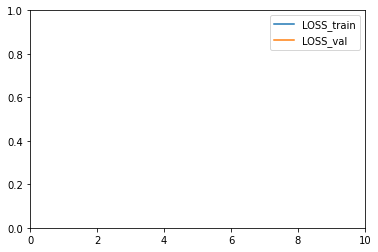

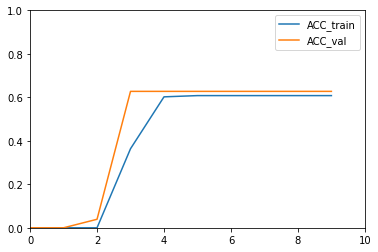

max ACC =  tensor(0.6275, device='cuda:0', dtype=torch.float64)


In [84]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [85]:
test_group_len = 26
PREDICTED, LABEL = predic_model(r_model_v3, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Versão 3')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor']
predições =  ['tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor']
matriz de confusão = 
 [[ 0 10]
 [ 0 16]]
Sensibilidade =  1.0
Especificidade =  0.0
acc =  0.6153846153846154


## Versão 4

Modelo que varia entre 5 otimizadores.

In [86]:
# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

##data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'
data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [87]:
# Carrega uma arquitetura já conhecida: ResNet18. O parâmetro "pretrained" define o uso ou não de "Transfer Learning"
model_v4 = models.resnet18(pretrained=False)
num_ftrs = model_v4.fc.in_features

# Define a sáida de tamanho 2 (Duas classes).
model_v4.fc = nn.Linear(num_ftrs, 2)

model_v4 = model_v4.to(device) #usa a GPU, se disponível e a CPU caso contrário

# Escolha da Loss Function (critério de otimização da classificação)
criterion = nn.CrossEntropyLoss()

optimizer = []

optimizer.append(optim.SGD(model_v4.parameters(), lr=0.001, momentum=0.9))
optimizer.append(optim.SGD(model_v4.parameters(), lr=0.0008, momentum=0.9))
optimizer.append(optim.SGD(model_v4.parameters(), lr=0.0001, momentum=0.9))
optimizer.append(optim.SGD(model_v4.parameters(), lr=0.00005, momentum=0.9))
optimizer.append(optim.SGD(model_v4.parameters(), lr=0.000005, momentum=0.9))

Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Epoch 0/9
----------
train Loss: 0.6832 Acc: 0.5909
val Loss: 0.6813 Acc: 0.5882

Epoch 1/9
----------
train Loss: 0.6329 Acc: 0.6477
val Loss: 0.6563 Acc: 0.6275

Epoch 2/9
----------
train Loss: 0.6529 Acc: 0.6080
val Loss: 0.6391 Acc: 0.6471

Epoch 3/9
----------
train Loss: 0.6340 Acc: 0.6477
val Loss: 0.6230 Acc: 0.6275

Epoch 4/9
----------
train Loss: 0.6392 Acc: 0.6250
val Loss: 0.6721 Acc: 0.5098

Epoch 5/9
----------
train Loss: 0.6326 Acc: 0.6477
val Loss: 0.6036 Acc: 0.6471

Epoch 6/9
----------
train Loss: 0.6172 Acc: 0.6250
val Loss: 0.6109 Acc: 0.7059

Epoch 7/9
----------
train Loss: 0.6336 Acc: 0.6534
val Loss: 0.6371 Acc: 0.5686

Epoch 8/9
----------
train Loss: 0.5895 Acc: 0.6818
val Loss: 0.5865 Acc: 0.7255

Epoch 9/9
----------
train Loss: 0.5836 Acc: 0.6761
val Loss: 0.6203 Acc: 0.6667

Training complete in 0m 15s
Best val Acc: 0.725490


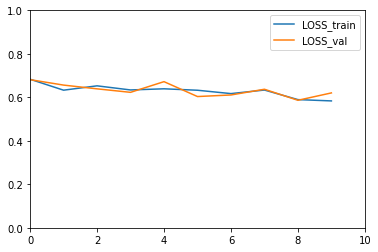

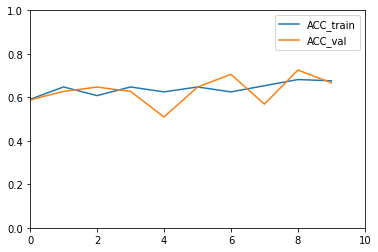

max ACC =  tensor(0.7255, device='cuda:0', dtype=torch.float64)

 Conjunto de Teste 

labels =  ['tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health']
predições =  ['tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'health', 'health']
matriz de confusão = 
 [[ 9  1]
 [ 4 12]]
Sensibilidade =  0.75
Especificidade =  0.9
acc =  0.8076923076923077



Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0008
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Epoch 0/9
----------
train Loss: 0.5728 Acc: 0.7102
val Loss: 0.6488 Acc: 0.5686

Epoch 1/9
----------
train Loss: 0.5815 Acc: 0.6818
val Loss: 0.6011 Acc:

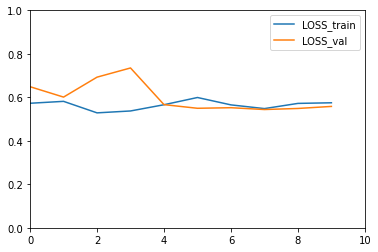

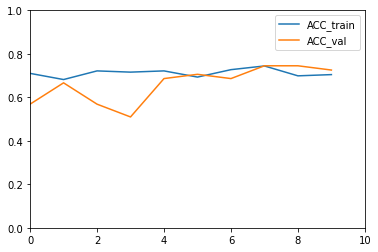

max ACC =  tensor(0.7451, device='cuda:0', dtype=torch.float64)

 Conjunto de Teste 

labels =  ['health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor']
predições =  ['health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor']
matriz de confusão = 
 [[ 9  1]
 [ 2 14]]
Sensibilidade =  0.875
Especificidade =  0.9
acc =  0.8846153846153846



Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Epoch 0/9
----------
train Loss: 0.5624 Acc: 0.7159
val Loss: 0.5511 Acc: 0.7255

Epoch 1/9
----------
train Loss: 0.5708 Acc: 0.7216
val Loss: 0.5465 Acc: 

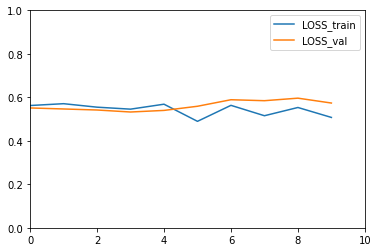

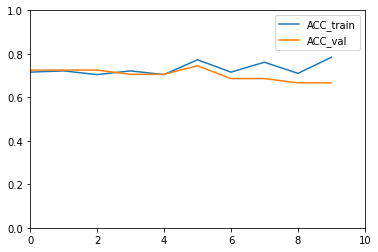

max ACC =  tensor(0.7451, device='cuda:0', dtype=torch.float64)

 Conjunto de Teste 

labels =  ['tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health']
predições =  ['tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'health', 'health']
matriz de confusão = 
 [[10  0]
 [ 3 13]]
Sensibilidade =  0.8125
Especificidade =  1.0
acc =  0.8846153846153846



Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    lr: 5e-05
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Epoch 0/9
----------
train Loss: 0.5581 Acc: 0.6989
val Loss: 0.5726 Acc: 0.7059

Epoch 1/9
----------
train Loss: 0.5094 Acc: 0.7614
val Loss: 0.5649 Acc

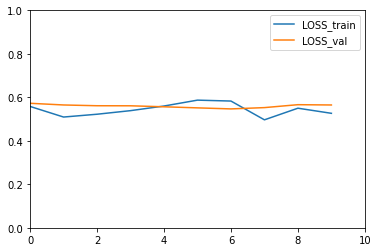

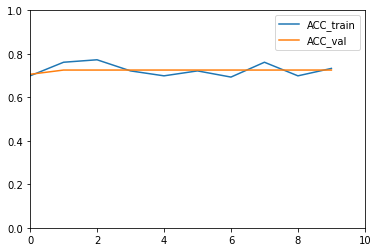

max ACC =  tensor(0.7255, device='cuda:0', dtype=torch.float64)

 Conjunto de Teste 

labels =  ['tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor']
predições =  ['tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor']
matriz de confusão = 
 [[10  0]
 [ 3 13]]
Sensibilidade =  0.8125
Especificidade =  1.0
acc =  0.8846153846153846



Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    lr: 5e-06
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Epoch 0/9
----------
train Loss: 0.5596 Acc: 0.7273
val Loss: 0.5561 Acc: 0.7255

Epoch 1/9
----------
train Loss: 0.5949 Acc: 0.7159
val Loss: 0.5616 Acc

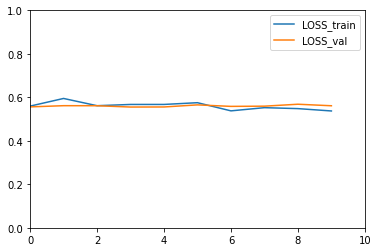

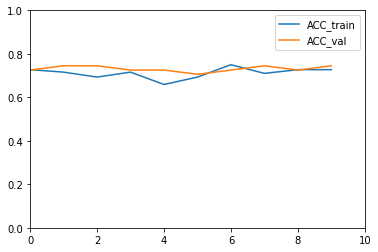

max ACC =  tensor(0.7451, device='cuda:0', dtype=torch.float64)

 Conjunto de Teste 

labels =  ['tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'health', 'health']
predições =  ['tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'health', 'health']
matriz de confusão = 
 [[10  0]
 [ 3 13]]
Sensibilidade =  0.8125
Especificidade =  1.0
acc =  0.8846153846153846





In [88]:
for opt in range(len(optimizer)):
  print('Optimizer: ', optimizer[opt])

  LOSS_train = []
  LOSS_val = []
  ACC_train = []
  ACC_val = []

  exp_lr_scheduler = lr_scheduler.StepLR(optimizer[opt], step_size=100, gamma=0.5)

  op_model_v4 = train_model(model_v4, criterion, optimizer[opt], exp_lr_scheduler, num_epochs=EPOCHS)

  LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
  plt.plot(LOSSES[:,:2])
  plt.axis([0, len(LOSSES), 0, 1])
  plt.legend(['LOSS_train','LOSS_val'])
  plt.show()
  plt.plot(LOSSES[:,2:])
  plt.axis([0, len(LOSSES), 0, 1])
  plt.legend(['ACC_train','ACC_val'])
  plt.show()
  print('max ACC = ', LOSSES[:,3:].max())

  test_group_len = 26
  PREDICTED, LABEL = predic_model(op_model_v4, plot_img = False, num_images=test_group_len)

  test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
  test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

  print('\n Conjunto de Teste \n')
  CM_test = confusion_matrix(LABEL, PREDICTED)
  Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
  Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
  print('labels = ', LABEL)
  print('predições = ', PREDICTED)
  print('matriz de confusão = \n', CM_test)
  print('Sensibilidade = ', Sensibilidade)
  print('Especificidade = ', Especificidade)
  print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)
  print('\n\n')

  title = 'Versão 4 com opitimizer ' + str(opt+1)
  string_all.append(title)
  sensibilidade_all.append(Sensibilidade)
  especificidade_all.append(Especificidade)
  acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

## Finetuning the resnet18

In [89]:
# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

##data_dir = 'gdrive/MyDrive/Brain_Tumor_Classification_Dataset/'
data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [90]:
# https://www.kaggle.com/vvijaybabu/2-class-classification-resnet-18-kernel

ngpus_per_node = torch.cuda.device_count()
feature_extract = False # if true this will not re-train the model, but only change the last stage
use_pretrained = True

# create model
print("=> creating model ")
model = models.resnet18(pretrained=use_pretrained) #pretrained=use_pretrained
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = torch.nn.DataParallel(model).cuda()

if feature_extract:
    for param in model.parameters():
        param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)            
model.to(device)

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda(ngpus_per_node)

modeldir = os.path.join('../data/', 'train')
# Data loading code
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#print("length", train_dataset.__len__)

#load the classification results
#now based on results, move the image to either of 2 classification bucket
#if dir "cactus" or "nocactus" is not present, create it

params_to_update = []

if feature_extract:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda(ngpus_per_node)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

=> creating model 


In [91]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

# Train and evaluate
model_resnet = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 0.6673 Acc: 0.6250
val Loss: 0.6207 Acc: 0.6078

Epoch 1/9
----------
train Loss: 0.6043 Acc: 0.6534
val Loss: 0.5853 Acc: 0.7255

Epoch 2/9
----------
train Loss: 0.4863 Acc: 0.8182
val Loss: 0.4354 Acc: 0.8431

Epoch 3/9
----------
train Loss: 0.4230 Acc: 0.8295
val Loss: 0.3660 Acc: 0.8627

Epoch 4/9
----------
train Loss: 0.4030 Acc: 0.8068
val Loss: 0.3373 Acc: 0.9216

Epoch 5/9
----------
train Loss: 0.4368 Acc: 0.7841
val Loss: 0.3320 Acc: 0.8824

Epoch 6/9
----------
train Loss: 0.4111 Acc: 0.8239
val Loss: 0.2920 Acc: 0.8824

Epoch 7/9
----------
train Loss: 0.3083 Acc: 0.8636
val Loss: 0.2883 Acc: 0.9020

Epoch 8/9
----------
train Loss: 0.2651 Acc: 0.8920
val Loss: 0.3046 Acc: 0.8627

Epoch 9/9
----------
train Loss: 0.2764 Acc: 0.8807
val Loss: 0.3358 Acc: 0.8627

Training complete in 0m 15s
Best val Acc: 0.921569


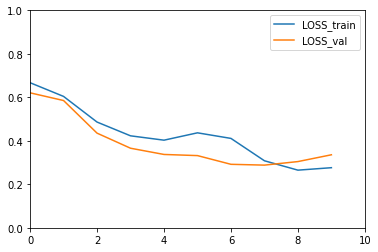

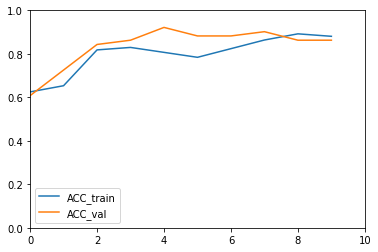

max ACC =  tensor(0.9216, device='cuda:0', dtype=torch.float64)


In [92]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [93]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model_resnet, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Finituning the resnet18')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health']
predições =  ['tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'health']
matriz de confusão = 
 [[10  0]
 [ 2 14]]
Sensibilidade =  0.875
Especificidade =  1.0
acc =  0.9230769230769231


## Finetuning the convnet

In [94]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

use_gpu = torch.cuda.is_available()

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [95]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_convnet = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 0.7605 Acc: 0.5341
val Loss: 0.6207 Acc: 0.7059

Epoch 1/9
----------
train Loss: 0.5760 Acc: 0.7102
val Loss: 0.5394 Acc: 0.7451

Epoch 2/9
----------
train Loss: 0.5430 Acc: 0.7443
val Loss: 0.4853 Acc: 0.7647

Epoch 3/9
----------
train Loss: 0.5048 Acc: 0.7727
val Loss: 0.4310 Acc: 0.8039

Epoch 4/9
----------
train Loss: 0.4295 Acc: 0.8068
val Loss: 0.3636 Acc: 0.8431

Epoch 5/9
----------
train Loss: 0.3464 Acc: 0.8693
val Loss: 0.3427 Acc: 0.8627

Epoch 6/9
----------
train Loss: 0.3452 Acc: 0.8352
val Loss: 0.2796 Acc: 0.8431

Epoch 7/9
----------
train Loss: 0.3158 Acc: 0.8693
val Loss: 0.2847 Acc: 0.8627

Epoch 8/9
----------
train Loss: 0.3201 Acc: 0.8750
val Loss: 0.2925 Acc: 0.8824

Epoch 9/9
----------
train Loss: 0.3165 Acc: 0.8864
val Loss: 0.3005 Acc: 0.8824

Training complete in 0m 15s
Best val Acc: 0.882353


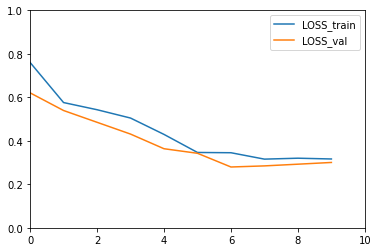

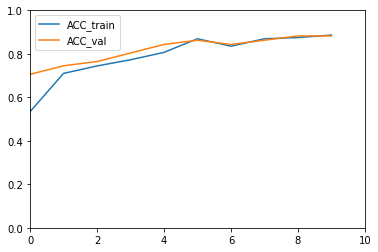

max ACC =  tensor(0.8824, device='cuda:0', dtype=torch.float64)


In [96]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [97]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model_convnet, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Finituning the convnet')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor']
predições =  ['tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor']
matriz de confusão = 
 [[10  0]
 [ 1 15]]
Sensibilidade =  0.9375
Especificidade =  1.0
acc =  0.9615384615384616


## ConvNet as fixed feature extractor

In [98]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [99]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_conv2 = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 0.6743 Acc: 0.6023
val Loss: 0.6727 Acc: 0.6275

Epoch 1/9
----------
train Loss: 0.6012 Acc: 0.6932
val Loss: 0.6218 Acc: 0.6078

Epoch 2/9
----------
train Loss: 0.6212 Acc: 0.6534
val Loss: 0.5890 Acc: 0.6275

Epoch 3/9
----------
train Loss: 0.5635 Acc: 0.6989
val Loss: 0.5231 Acc: 0.6667

Epoch 4/9
----------
train Loss: 0.5405 Acc: 0.7045
val Loss: 0.4558 Acc: 0.7647

Epoch 5/9
----------
train Loss: 0.5052 Acc: 0.7614
val Loss: 0.4415 Acc: 0.8039

Epoch 6/9
----------
train Loss: 0.4824 Acc: 0.7784
val Loss: 0.4455 Acc: 0.7843

Epoch 7/9
----------
train Loss: 0.4740 Acc: 0.7784
val Loss: 0.4497 Acc: 0.7843

Epoch 8/9
----------
train Loss: 0.4331 Acc: 0.8011
val Loss: 0.4550 Acc: 0.7843

Epoch 9/9
----------
train Loss: 0.4746 Acc: 0.7614
val Loss: 0.4683 Acc: 0.7451

Training complete in 0m 14s
Best val Acc: 0.803922


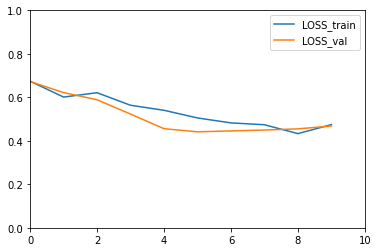

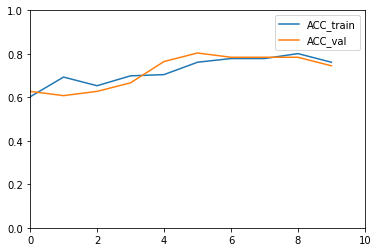

max ACC =  tensor(0.8039, device='cuda:0', dtype=torch.float64)


In [100]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [101]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model_conv2, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('ConvNet as fixed feature extractor')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['health', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health']
predições =  ['health', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health']
matriz de confusão = 
 [[10  0]
 [ 2 14]]
Sensibilidade =  0.875
Especificidade =  1.0
acc =  0.9230769230769231


## Adicionando camadas

Adiciona algumas camadas ao modelo pré-treinado:

* Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
* Sequencial()
* AdaptiveAvgPool2d(1)
* model_ft.fc.out_features = 200

In [102]:
model_ft = models.resnet18()
model_ft.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
model_ft.maxpool = nn.Sequential()
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
model_ft.fc.out_features = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [103]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_camadas = train_model(model_ft, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 6.0619 Acc: 0.2330
val Loss: 5.0281 Acc: 0.6275

Epoch 1/9
----------
train Loss: 1.9174 Acc: 0.6080
val Loss: 1.5590 Acc: 0.6275

Epoch 2/9
----------
train Loss: 0.7154 Acc: 0.6250
val Loss: 0.7739 Acc: 0.4314

Epoch 3/9
----------
train Loss: 0.7587 Acc: 0.5625
val Loss: 0.6641 Acc: 0.6275

Epoch 4/9
----------
train Loss: 0.6911 Acc: 0.5966
val Loss: 0.6914 Acc: 0.5686

Epoch 5/9
----------
train Loss: 0.6511 Acc: 0.6307
val Loss: 0.6422 Acc: 0.6275

Epoch 6/9
----------
train Loss: 0.6411 Acc: 0.6193
val Loss: 0.6790 Acc: 0.6471

Epoch 7/9
----------
train Loss: 0.6381 Acc: 0.6307
val Loss: 0.6736 Acc: 0.6275

Epoch 8/9
----------
train Loss: 0.6362 Acc: 0.6364
val Loss: 0.6666 Acc: 0.6863

Epoch 9/9
----------
train Loss: 0.6340 Acc: 0.6534
val Loss: 0.6637 Acc: 0.6667

Training complete in 1m 19s
Best val Acc: 0.686275


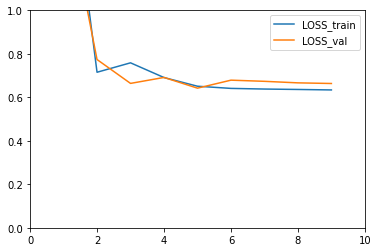

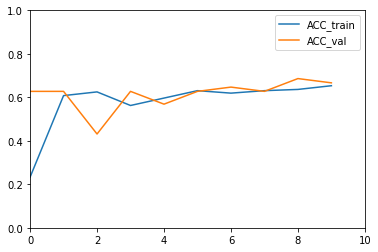

max ACC =  tensor(0.6863, device='cuda:0', dtype=torch.float64)


In [104]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [105]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model_camadas, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Adicionando camadas')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor']
predições =  ['tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'health', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor']
matriz de confusão = 
 [[ 7  3]
 [ 2 14]]
Sensibilidade =  0.875
Especificidade =  0.7
acc =  0.8076923076923077


## Modelo Geral

Cria um modelo como algumas funções adicionais.

In [106]:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [107]:
data_dir = '/content/DataSets/Brain_Tumor/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [108]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [109]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)

In [110]:
# Data augmentation and normalization for training

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/DataSets/Brain_Tumor/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [111]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [112]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/9
----------
train Loss: 0.7992 Acc: 0.5398
val Loss: 0.6554 Acc: 0.6471

Epoch 1/9
----------
train Loss: 0.6095 Acc: 0.6591
val Loss: 0.5258 Acc: 0.7451

Epoch 2/9
----------
train Loss: 0.5351 Acc: 0.7386
val Loss: 0.5419 Acc: 0.7255

Epoch 3/9
----------
train Loss: 0.4389 Acc: 0.8352
val Loss: 0.4151 Acc: 0.8039

Epoch 4/9
----------
train Loss: 0.5861 Acc: 0.6989
val Loss: 0.3924 Acc: 0.8627

Epoch 5/9
----------
train Loss: 0.4509 Acc: 0.8011
val Loss: 0.3977 Acc: 0.7843

Epoch 6/9
----------
train Loss: 0.4721 Acc: 0.7898
val Loss: 0.3385 Acc: 0.9216

Epoch 7/9
----------
train Loss: 0.4085 Acc: 0.8523
val Loss: 0.3392 Acc: 0.9020

Epoch 8/9
----------
train Loss: 0.4292 Acc: 0.8125
val Loss: 0.3410 Acc: 0.9020

Epoch 9/9
----------
train Loss: 0.3941 Acc: 0.8239
val Loss: 0.3386 Acc: 0.8824

Training complete in 0m 13s
Best val Acc: 0.921569


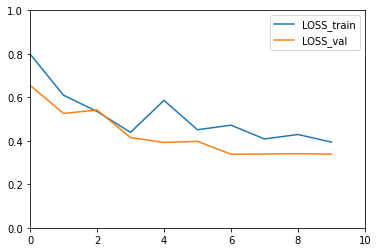

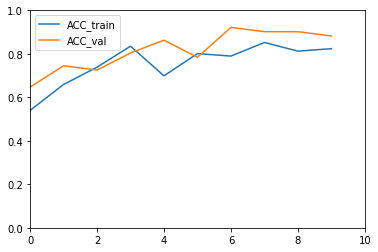

max ACC =  tensor(0.9216, device='cuda:0', dtype=torch.float64)


In [113]:
LOSSES = np.array([LOSS_train,LOSS_val,ACC_train,ACC_val]).T
         
plt.plot(LOSSES[:,:2])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['LOSS_train','LOSS_val'])
plt.show()
plt.plot(LOSSES[:,2:])
plt.axis([0, len(LOSSES), 0, 1])
plt.legend(['ACC_train','ACC_val'])
plt.show()
print('max ACC = ', LOSSES[:,3:].max())

In [114]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model_ft, plot_img = False, num_images=test_group_len)

test_health_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'health'])
test_tumor_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'tumor'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_tumor_size # Sensibilidade: é a razão entre as imagens com tumor classificadas corretamente e o total de imagens com tumor (Verdadeiros positivos ÷ tumores)
Especificidade = CM_test[0,0]/test_health_size # Especificidade: é a razão entre as imagens sem tumor classificadas corretamente e o total de imagens sem tumor (Verdadeiros negativos ÷ sadios)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)

string_all.append('Modelo Geral')
sensibilidade_all.append(Sensibilidade)
especificidade_all.append(Especificidade)
acc_all.append(len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  ['tumor', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'health', 'tumor', 'tumor', 'tumor', 'health', 'health']
predições =  ['tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'tumor', 'health', 'tumor', 'tumor', 'health', 'tumor', 'health', 'tumor', 'tumor', 'health', 'health', 'tumor', 'tumor', 'tumor', 'tumor', 'health', 'health']
matriz de confusão = 
 [[ 9  1]
 [ 1 15]]
Sensibilidade =  0.9375
Especificidade =  0.9
acc =  0.9230769230769231


# Resultados

In [115]:
for i in range(len(string_all)):
  print(string_all[i])
  print('Sensibilidade: ', sensibilidade_all[i])
  print('Especificidade: ', especificidade_all[i])
  print('Accuracy: ', acc_all[i])
  print('\n')

Original
Sensibilidade:  1.0
Especificidade:  0.0
Accuracy:  0.6153846153846154


Versão 1
Sensibilidade:  1.0
Especificidade:  0.3
Accuracy:  0.7307692307692307


Versão 2
Sensibilidade:  1.0
Especificidade:  0.2
Accuracy:  0.6923076923076923


Versão 3
Sensibilidade:  1.0
Especificidade:  0.0
Accuracy:  0.6153846153846154


Versão 4 com opitimizer 1
Sensibilidade:  0.75
Especificidade:  0.9
Accuracy:  0.8076923076923077


Versão 4 com opitimizer 2
Sensibilidade:  0.875
Especificidade:  0.9
Accuracy:  0.8846153846153846


Versão 4 com opitimizer 3
Sensibilidade:  0.8125
Especificidade:  1.0
Accuracy:  0.8846153846153846


Versão 4 com opitimizer 4
Sensibilidade:  0.8125
Especificidade:  1.0
Accuracy:  0.8846153846153846


Versão 4 com opitimizer 5
Sensibilidade:  0.8125
Especificidade:  1.0
Accuracy:  0.8846153846153846


Finituning the resnet18
Sensibilidade:  0.875
Especificidade:  1.0
Accuracy:  0.9230769230769231


Finituning the convnet
Sensibilidade:  0.9375
Especificidade:  1.0

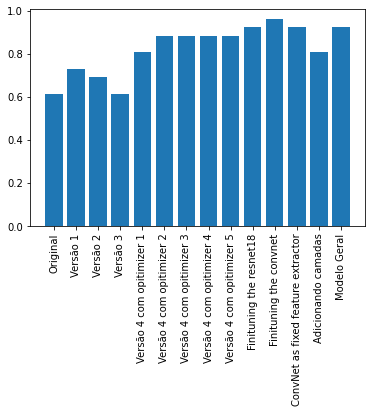

In [119]:
import matplotlib.pyplot as plt

plt.bar(string_all,acc_all)
plt.xticks(rotation=90)
plt.show()